<h1 style="font-size: 50px">Real-World Graphs</h1>

# imports, settings and needed functions

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.metrics import pairwise_distances
from graph import Graph
from helpers import get_hermitian_adjacency_matrix, get_adjacency_matrix, get_degree_matrix, get_laplacian_matrix

In [2]:
np.random.seed(9)
font = {'size'   : 16}

plt.rc('font', **font)

General Functions

In [3]:
def knn_adjacency_matrix(features, k, metric='euclidean'):
    if k <= 0:
        raise ValueError("k must be a positive integer.")

    # Compute the pairwise distances
    distances = pairwise_distances(features, metric=metric)

    # Get the indices of the k-nearest neighbors for each point
    knn_indices = np.argsort(distances, axis=1)[:, 1:k+1]

    # Initialize the adjacency matrix
    n_points = features.shape[0]
    adjacency_matrix = np.zeros((n_points, n_points), dtype=float)

    # Fill the adjacency matrix
    for i in range(n_points):
        for j in knn_indices[i]:
            adjacency_matrix[i, j] = 1
            adjacency_matrix[j, i] = 1  # Ensure the graph is undirected

    return adjacency_matrix
def get_thresholded_correlation_matrix(features, threshold):
    correlation_matrix = np.corrcoef(features)

    # Create a graph using the correlation matrix
    correlation_matrix[correlation_matrix < threshold] = 0
    return correlation_matrix
                

def get_normalised_laplacian(A):
    degrees = np.sum(A, axis=1)
    D_inv_sqrt = np.diag([1/np.sqrt(d) for d in degrees])
    return np.eye(len(A)) - D_inv_sqrt @ A @ D_inv_sqrt


def k_means_indicator_vectors(eigenvectors, K):
    assert eigenvectors.shape[1] >= K, 'Number of eigenvectors should be greater than or equal to K'
    kmeans = KMeans(n_clusters=K, random_state=0).fit(eigenvectors)
    indicator_vectors = np.zeros((eigenvectors.shape[0], K))
    for i in range(K):
        indicator_vectors[:,i] = kmeans.labels_ == i
    return indicator_vectors

def degree_correction(vectors, D_sqrt):
    vectors_corrected = vectors.copy()
    for i in range(vectors.shape[1]):
        vectors_corrected[:,i] = D_sqrt @ vectors[:,i]
        vectors_corrected[:,i] = vectors_corrected[:,i] / np.linalg.norm(vectors_corrected[:,i])
    return vectors_corrected

def compute_rayleigh_quotients(normalised_L, indicator_vectors, K):
    rayleigh_quotients = []
    assert indicator_vectors.shape[1] == K, 'Indicator vectors should have K columns'
    for i in range(K):
        indicator = indicator_vectors[:, i]
        val = (indicator.T @ normalised_L @ indicator) / (indicator.T @ indicator)
        rayleigh_quotients.append(val)
    return rayleigh_quotients


def dfs(node, adj_matrix, visited, component):
    """
    Depth-first search to collect all nodes in the same connected component.

    Parameters:
        node (int): The current node being visited.
        adj_matrix (numpy.ndarray): The adjacency matrix of the graph.
        visited (set): A set of visited nodes.
        component (list): List to store nodes in the current component.
    """
    visited.add(node)
    component.append(node)
    for neighbor, is_connected in enumerate(adj_matrix[node]):
        if is_connected and neighbor not in visited:
            dfs(neighbor, adj_matrix, visited, component)

def largest_connected_component(adj_matrix):
    """
    Finds the largest connected component of a graph from its adjacency matrix.

    Parameters:
        adj_matrix (numpy.ndarray): The adjacency matrix of the graph.

    Returns:
        numpy.ndarray: The adjacency matrix of the largest connected component.
        list: indices of nodes in largest component.
    """
    n = len(adj_matrix)
    visited = set()
    components = []

    # Find all connected components
    for node in range(n):
        if node not in visited:
            component = []
            dfs(node, adj_matrix, visited, component)
            components.append(component)

    # Identify the largest connected component
    largest_cc = max(components, key=len)

    # Create the adjacency matrix for the largest connected component
    size = len(largest_cc)
    largest_cc_matrix = np.zeros((size, size), dtype=int)

    node_index = {node: i for i, node in enumerate(largest_cc)}
    for i in largest_cc:
        for j in largest_cc:
            if adj_matrix[i][j]:
                largest_cc_matrix[node_index[i]][node_index[j]] = 1

    return largest_cc_matrix, largest_cc


Simple search algorithm for finding a good split of eigenvalues to apply the recursive structure theorem

In [4]:
def apply_recursive_st(rayleigh_quotients, eigenvalues, start, end, error):
    R = rayleigh_quotients[start:end]
    l = end-start
    val = np.sum(R) - l * eigenvalues[start] + eigenvalues[end] * error
    if (eigenvalues[end] != eigenvalues[start]) and (eigenvalues[end] != 0):
        val = val / (eigenvalues[end] - eigenvalues[start])
        print(val)
        return val
    else:
        return 0
    
def apply_recursive_st_search(rayleigh_quotients, eigenvalues, start, error, bound_indices, values):
    # we begin initial search for first error bound
    indices = list(range(len(eigenvalues)))
    if bound_indices and max(bound_indices) == len(eigenvalues)-1:
        return bound_indices, values
    else:
        vals_temp = []
        indices_to_search = indices[start+1:]
        for end in indices_to_search:
            vals_temp.append(apply_recursive_st(rayleigh_quotients, eigenvalues, start, end, error = error))
        min_val = min(vals_temp)
        min_index = vals_temp.index(min_val)
        bound_indices.append(indices_to_search[min_index])
        values.append(min_val)
        print(f"Difference between {start} and {bound_indices[-1]}")
        print("Rayleigh quotient indices accounted for: ")
        return apply_recursive_st_search(rayleigh_quotients, eigenvalues, start=bound_indices[-1], error = np.sum(values), bound_indices=bound_indices, values = values)


ATTEMPT TO IMPROVE RECURSIVE ST SEARCH

In [5]:
def apply_recursive_st_search_2step(rayleigh_quotients, eigenvalues, start, error, bound_indices, values):
    # we begin initial search for first error bound
    indices = list(range(len(eigenvalues)))
    if bound_indices and max(bound_indices) == len(eigenvalues)-1:
        return bound_indices, values
    else:
        vals_temp_second_step = []
        vals_temp = []
        indices_to_search = indices[start+1:]
        for end in indices_to_search:
            val = apply_recursive_st(rayleigh_quotients, eigenvalues, start, end, error = error)
            _, v = apply_recursive_st_search(rayleigh_quotients, eigenvalues, start=end, error = np.sum(values) + val, bound_indices=bound_indices, values = values)
            vals_temp_second_step.append(np.sum(v) + val)
            vals_temp.append(val)
        min_val_second_step = min(vals_temp_second_step)
        min_index = vals_temp_second_step.index(min_val_second_step)
        min_val = vals_temp[min_index]
        bound_indices.append(indices_to_search[min_index])
        values.append(min_val)
        print(f"Difference between {start} and {bound_indices[-1]}")
        print("Rayleigh quotient indices accounted for: ")
        return apply_recursive_st_search(rayleigh_quotients, eigenvalues, start=bound_indices[-1], error = np.sum(values), bound_indices=bound_indices, values = values)


VERSION WITHOUT SEARCHING

In [6]:
# for this version we have to specify the indices where we want to compute the recursive st on. so if we passed in [0,1,K] this would achieve the bounds from corollary 5. You must start from 0 and end with K. It will consider from 0 to K-1 (the first K terms)  in the sum. 
def apply_recursive_st_given_indices(rayleigh_quotients, eigenvalues, indices):
    values = []
    for i, i_add_1 in zip(indices, indices[1:]):
        error = np.sum(values)
        val = apply_recursive_st(rayleigh_quotients, eigenvalues, i, i_add_1, error)
        values.append(val)
    return values

A function for generating increasing list from 0 to K.

In [7]:
from itertools import combinations

def generate_increasing_lists(K):
    """
    Generate all lists of increasing integers from 0 to K.

    Parameters:
    K (int): A positive integer.

    Returns:
    list: A list of lists containing increasing sequences from 0 to K.
    """
    if K < 0:
        raise ValueError("K must be a positive integer")

    # Create the range of numbers from 0 to K
    numbers = list(range(K + 1))

    # Generate all combinations of indices (at least 2 elements: 0 and K are mandatory)
    result = []
    for r in range(2, len(numbers) + 1):
        for combination in combinations(numbers[1:-1], r - 2):
            result.append([0] + list(combination) + [K])

    return result

In [8]:
dataset_results = {}

# MNIST Dataset

In [52]:
# Load the MNIST dataset using OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
x_data, y_data = mnist.data, mnist.target.astype(int)

# Select 3 digits (e.g., 0, 1, and 2) and restrict to 200 samples each
digits = [0, 1, 2, 3, 4]
samples_per_digit = 500
selected_samples = []
selected_labels = []

# taking a sample of each digit
for digit in digits:
    indices = np.where(y_data == digit)[0][:samples_per_digit]
    selected_samples.append(x_data[indices])
    selected_labels.extend(y_data[indices])

# Combine the samples into a single dataset
selected_samples = np.vstack(selected_samples) / 255.0  # Normalize pixel values
selected_labels = np.array(selected_labels)

# Create a graph using the correlation matrix
threshold = 0.7  # Define a threshold for edge creation
adjacency_matrix = get_thresholded_correlation_matrix(selected_samples, threshold)
adjacency_matrix_largest_cc, largest_cc = largest_connected_component(adjacency_matrix) 
normalized_laplacian = get_normalised_laplacian(adjacency_matrix_largest_cc)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [53]:
# compute first K eigenvectors of the normalized Laplacian
K=5
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix_largest_cc, axis = 0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                    combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                         i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: >

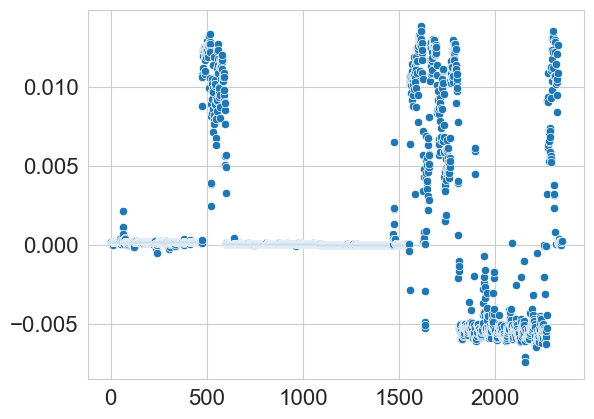

In [59]:
D_inv_sqrt = np.diag(np.sqrt([1/d for d in degrees]))
#sns.scatterplot(D_inv_sqrt @ normalized_L_eigenvectors[:,1])
#sns.scatterplot(D_inv_sqrt @ normalized_L_eigenvectors[:,2])
#sns.scatterplot(D_inv_sqrt @ normalized_L_eigenvectors[:,3])
sns.scatterplot(D_inv_sqrt @ normalized_L_eigenvectors[:,4])

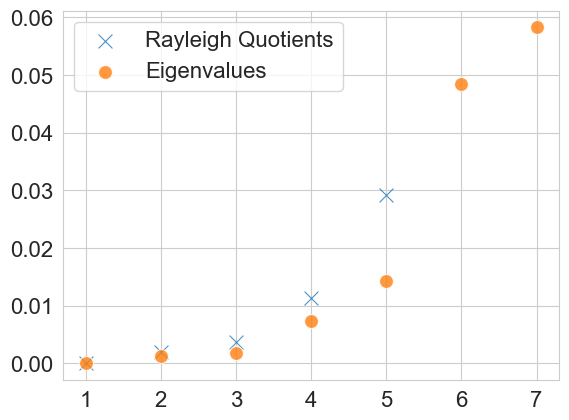

In [10]:
# plot of eigenvalues and rayleigh quotients
sns.scatterplot(x = [1,2,3,4,5],y = rayleigh_quotients, alpha = 0.8, marker='x', s=100, label='Rayleigh Quotients')
sns.scatterplot(x = [1,2,3,4,5,6,7], y = normalized_L_eigenvalues[0:7], alpha = 0.8, marker = 'o',s=100, label='Eigenvalues')
plt.legend()

In [11]:
true_val_matrix_combined = normalized_L_eigenvectors[:,:5] - indicator_vectors @ (indicator_vectors.T @ normalized_L_eigenvectors[:,:5])
true_val_combined = (1/5) * np.linalg.norm(true_val_matrix_combined)**2

In [106]:
v = apply_recursive_st_given_indices(rayleigh_quotients[0:5], normalized_L_eigenvalues[0:6], [0,1,5])

2.444923357268638e-13
0.8721329683693108


0.17442659367391106

In [40]:
mnist_dataset_results = {}
print("K: ", K)
mnist_dataset_results["K"] = K
print("Number of vertices N: ", len(adjacency_matrix_largest_cc))
mnist_dataset_results["N"] = len(adjacency_matrix_largest_cc)
print("Number of edges M: ", np.sum(np.sum(adjacency_matrix_largest_cc, axis=1), axis=0))
mnist_dataset_results["M"] = np.sum(np.sum(adjacency_matrix_largest_cc, axis=1), axis=0)
print("True value: ", true_val_combined)
mnist_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K])
mnist_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K]))
mnist_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K])
print("Recursive ST: ", np.sum(v)/5)
mnist_dataset_results["Recursive ST"] = np.sum(v)/5

dataset_results["MNIST"] = mnist_dataset_results

K:  5
Number of vertices N:  2348
Number of edges M:  140018
True value:  0.01277183842880367
M&S ST:  0.43945091443546835
General ST:  0.1914964218584773
Recursive ST:  0.17442659367391106


# Fashion MNIST

In [60]:
# Load the MNIST dataset using OpenML
mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
x_data, y_data = mnist.data, mnist.target.astype(int)

# Select 3 digits (e.g., 0, 1, and 2) and restrict to 200 samples each
digits = [0, 1, 2]
samples_per_digit = 1000
selected_samples = []
selected_labels = []

# taking a sample of each digit
for digit in digits:
    indices = np.where(y_data == digit)[0][:samples_per_digit]
    selected_samples.append(x_data[indices])
    selected_labels.extend(y_data[indices])

# Combine the samples into a single dataset
selected_samples = np.vstack(selected_samples) / 255.0  # Normalize pixel values
selected_labels = np.array(selected_labels)

# Create a graph using the correlation matrix
threshold = 0.7  # Define a threshold for edge creation
adjacency_matrix = get_thresholded_correlation_matrix(selected_samples, threshold)
adjacency_matrix_largest_cc, largest_cc = largest_connected_component(adjacency_matrix) 


C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [101]:
vertices_to_remove = [318,319,320]
adjacency_matrix_largest_cc = np.delete(adjacency_matrix_largest_cc, vertices_to_remove, axis=0)
adjacency_matrix_largest_cc = np.delete(adjacency_matrix_largest_cc, vertices_to_remove, axis=1)
normalized_laplacian = get_normalised_laplacian(adjacency_matrix_largest_cc)

<Axes: >

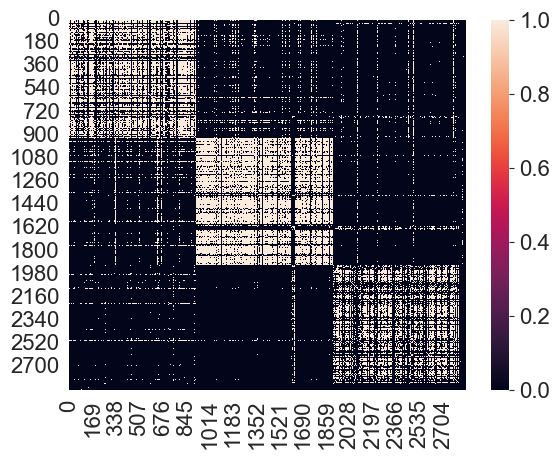

In [102]:
sns.heatmap(adjacency_matrix_largest_cc)

In [113]:
# compute first K eigenvectors of the normalized Laplacian
K=6
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix_largest_cc, axis = 0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                    combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                         i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [83]:
indicator_vectors

array([[0.02174388, 0.        , 0.        ],
       [0.02472417, 0.        , 0.        ],
       [0.02714987, 0.        , 0.        ],
       ...,
       [0.0012203 , 0.        , 0.        ],
       [0.0012203 , 0.        , 0.        ],
       [0.0012203 , 0.        , 0.        ]])

In [73]:
kmeans = KMeans(n_clusters=K, random_state=0).fit(normalized_L_eigenvectors[:, 0:K])
ts = pd.Series(kmeans.labels_)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: >

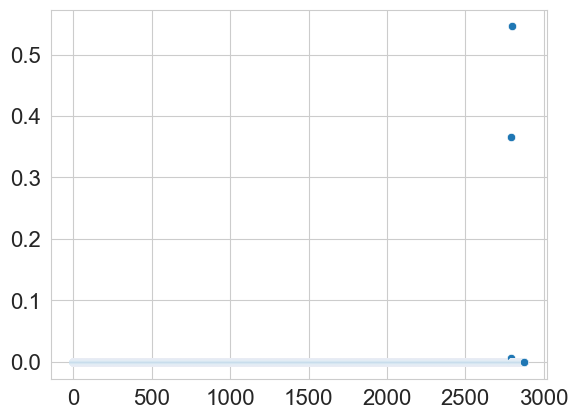

In [69]:
D_inv_sqrt = np.diag(np.sqrt([1/d for d in degrees]))
#sns.scatterplot(D_inv_sqrt @ normalized_L_eigenvectors[:,1])
#sns.scatterplot(D_inv_sqrt @ normalized_L_eigenvectors[:,2])
#sns.scatterplot(D_inv_sqrt @ normalized_L_eigenvectors[:,3])
sns.scatterplot(D_inv_sqrt @ normalized_L_eigenvectors[:,4])

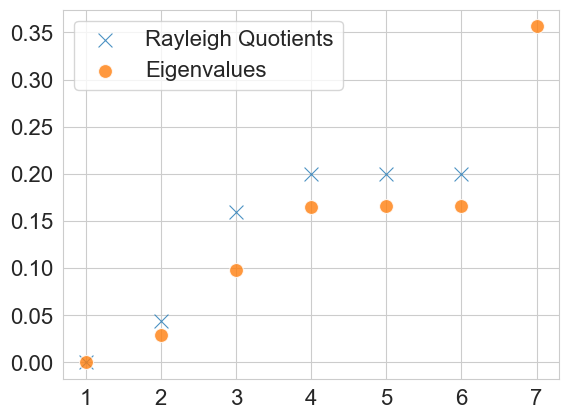

In [114]:
# plot of eigenvalues and rayleigh quotients
sns.scatterplot(x=[1, 2, 3, 4, 5, 6], y=rayleigh_quotients, alpha=0.8, marker='x', s=100, label='Rayleigh Quotients')
sns.scatterplot(x=[1, 2, 3, 4, 5, 6, 7], y=normalized_L_eigenvalues[0:7], alpha=0.8, marker='o', s=100, label='Eigenvalues')
plt.legend()

In [15]:
b, v = apply_recursive_st_search(rayleigh_quotients[0:4], normalized_L_eigenvalues[0:4], 0, error = 0, bound_indices = [], values = [])
np.sum(v)/3

1.7102204913152657e-14
0.9439147809984682
1.6060111754113842
Difference between 0 and 1
Rayleigh quotient indices accounted for: 
0.892302020502785
1.4375445436022487
Difference between 1 and 2
Rayleigh quotient indices accounted for: 
3.4222890474929346
Difference between 2 and 3
Rayleigh quotient indices accounted for: 


1.4381970226652456

In [120]:
v = apply_recursive_st_given_indices(rayleigh_quotients[0:6], normalized_L_eigenvalues[0:7], [0,1,2,6])
np.sum(v)/6

-1.772993684719872e-14
0.21672287455415215
1.7181475821291299


0.3224784094472107

In [117]:
true_val_matrix_combined = normalized_L_eigenvectors[:, :6] - indicator_vectors @ (
            indicator_vectors.T @ normalized_L_eigenvectors[:, :6])
true_val_combined = (1 / 6) * np.linalg.norm(true_val_matrix_combined) ** 2

fashion_mnist_dataset_results = {}
print("K: ", K)
fashion_mnist_dataset_results["K"] = K
print("Number of vertices N: ", len(adjacency_matrix_largest_cc))
fashion_mnist_dataset_results["N"] = len(adjacency_matrix_largest_cc)
print("Number of edges M: ", np.sum(np.sum(adjacency_matrix_largest_cc, axis=1), axis=0))
fashion_mnist_dataset_results["M"] = np.sum(np.sum(adjacency_matrix_largest_cc, axis=1), axis=0)
print("True value: ", true_val_combined)
fashion_mnist_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K])
fashion_mnist_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K]))
fashion_mnist_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K])
print("Recursive ST: ", np.sum(v)/6)
fashion_mnist_dataset_results["Recursive ST"] = np.sum(v)/6

dataset_results["Fashion MNIST"] = fashion_mnist_dataset_results

K:  6
Number of vertices N:  2872
Number of edges M:  1711206
True value:  0.03465416597487895
M&S ST:  0.5613847171007009
General ST:  0.3760754278388082
Recursive ST:  0.3224784094472107


# IRIS

In [121]:
iris = fetch_openml('iris', version=1, as_frame=False)
x_data, y_data = iris.data, iris.target

targets = np.unique(y_data).tolist()

selected_samples = []
selected_labels = []

for target in targets:
    indices = np.where(y_data == target)[0]
    selected_samples.append(x_data[indices])
    selected_labels.extend(y_data[indices])

selected_samples = np.vstack(selected_samples)
selected_labels = np.array(selected_labels)
# Calculate the Pearson correlation matrix
adjacency_matrix = knn_adjacency_matrix(x_data,5)
normalized_laplacian = get_normalised_laplacian(adjacency_matrix)


C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [123]:
# compute first K eigenvectors of the normalized Laplacian
K=5
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix, axis = 0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                    combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                         i]) * combined_indicator_vectors[:, j]

# rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: >

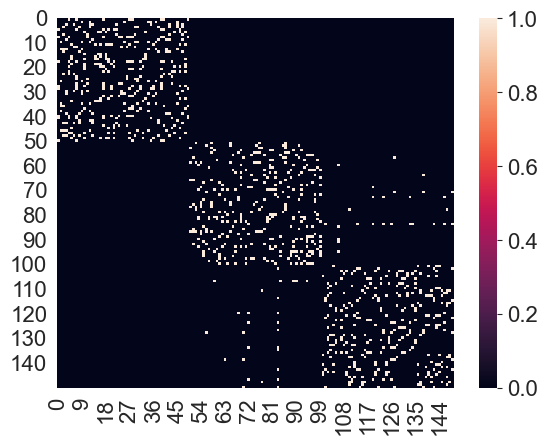

In [20]:
sns.heatmap(adjacency_matrix)

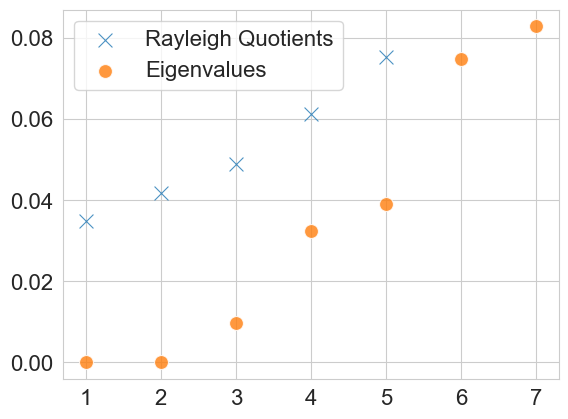

In [124]:
# plot of eigenvalues and rayleigh quotients
sns.scatterplot(x=[1, 2, 3, 4, 5], y=rayleigh_quotients, alpha=0.8, marker='x', s=100, label='Rayleigh Quotients')
sns.scatterplot(x=[1, 2, 3, 4, 5, 6, 7], y=normalized_L_eigenvalues[0:7], alpha=0.8, marker='o', s=100, label='Eigenvalues')
plt.legend()

In [28]:
rayleigh_quotients = np.round(rayleigh_quotients,6)
normalized_L_eigenvalues = np.round(normalized_L_eigenvalues,6)
# b, v = apply_recursive_st_search(rayleigh_quotients[0:4], normalized_L_eigenvalues[0:4], 0, error = 0, bound_indices = [], values = [])
v = apply_recursive_st_given_indices(rayleigh_quotients[0:4], normalized_L_eigenvalues[0:5], [0,1,3])
np.sum(v)/3

1.0081185368112362


0.33603951227041207

In [29]:
true_val_matrix_combined = normalized_L_eigenvectors[:, :3] - indicator_vectors @ (
            indicator_vectors.T @ normalized_L_eigenvectors[:, :3])
true_val_combined = (1 / 3) * np.linalg.norm(true_val_matrix_combined) ** 2
true_val_combined

0.05993164395890421

In [30]:
true_val_matrix_combined = normalized_L_eigenvectors[:, :3] - combined_indicator_vectors @ (
            combined_indicator_vectors.T @ normalized_L_eigenvectors[:, :3])
true_val_combined = (1 / 3) * np.linalg.norm(true_val_matrix_combined) ** 2
true_val_combined

0.05993164395890421

In [31]:
true_val_matrix_combined = normalized_L_eigenvectors[:, :3] - indicator_vectors @ (
            indicator_vectors.T @ normalized_L_eigenvectors[:, :3])
true_val_combined = (1 / 3) * np.linalg.norm(true_val_matrix_combined) ** 2
print("N: ", len(adjacency_matrix))
print("K: ", K)
print("True value: ", true_val_combined)
print("M&S ST: ",
      max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors)) / normalized_L_eigenvalues[K])
#print("General ST: ", max(rayleigh_quotients)/normalized_L_eigenvalues[K])

B_1 = rayleigh_quotients[0] / normalized_L_eigenvalues[1] if rayleigh_quotients[0] > 0 else 0
B_2 = ((rayleigh_quotients[1] - normalized_L_eigenvalues[1]) + normalized_L_eigenvalues[2] * B_1) / (
            normalized_L_eigenvalues[2] - normalized_L_eigenvalues[1]) if rayleigh_quotients[1] > 0 else 0
B_3 = ((rayleigh_quotients[2] - normalized_L_eigenvalues[2]) + normalized_L_eigenvalues[3] * (B_1 + B_2)) / (
            normalized_L_eigenvalues[3] - normalized_L_eigenvalues[2])
print("Recursive ST: ", (B_1 + B_2 + B_3) / 3)

iris_dataset_results = {}
print("K: ", K)
iris_dataset_results["K"] = K
print("Number of vertices N: ", len(adjacency_matrix))
iris_dataset_results["N"] = len(adjacency_matrix)
print("Number of edges M: ", np.sum(np.sum(adjacency_matrix, axis=1), axis=0))
iris_dataset_results["M"] = np.sum(np.sum(adjacency_matrix, axis=1), axis=0)
print("True value: ", true_val_combined)
iris_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K])
iris_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K]))
iris_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K])
print("Recursive ST: ", np.sum(v)/K)
iris_dataset_results["Recursive ST"] = np.sum(v)/K

dataset_results["IRIS"] = iris_dataset_results

N:  150
K:  3
True value:  0.05993164395890421
M&S ST:  0.6457941686078185
Recursive ST:  1.1401455058366565
K:  3
Number of vertices N:  150
Number of edges M:  1027.0
True value:  0.05993164395890421
M&S ST:  0.6457941686078185
General ST:  0.3360395122704121
Recursive ST:  0.33603951227041207


In [32]:
iris_dataset_results = {}
print("K: ", K)
iris_dataset_results["K"] = K
print("Number of vertices N: ", len(adjacency_matrix))
iris_dataset_results["N"] = len(adjacency_matrix)
print("Number of edges M: ", np.sum(np.sum(adjacency_matrix, axis=1), axis=0))
iris_dataset_results["M"] = np.sum(np.sum(adjacency_matrix, axis=1), axis=0)
print("True value: ", true_val_combined)
iris_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K])
iris_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K]))
iris_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K])
print("Recursive ST: ", np.sum(v)/K)
iris_dataset_results["Recursive ST"] = np.sum(v)/K

dataset_results["IRIS"] = iris_dataset_results

K:  3
Number of vertices N:  150
Number of edges M:  1027.0
True value:  0.05993164395890421
M&S ST:  0.6457941686078185
General ST:  0.3360395122704121
Recursive ST:  0.33603951227041207


| Dataset         | N   | K | True Value | M&S ST  | Recursive ST |
|-----------------|-----|---|------------|---------|--------------|
| MNIST           | 530 | 3 | 0.0152     | 0.4705  | 0.1653       |
| Fashion MNIST   | 560 | 3 | 0.0306     | 0.2987  | 0.1696       |
| IRIS            | 150 | 3 | 0.0599     | 0.6458  | 0.3377       |



# Wine Dataset

In [33]:
wine_df = pd.read_csv("Data/Wine dataset.csv")

In [34]:
wine_df_targets = wine_df['class']
wine_df_features = wine_df.drop(columns = ['class'])
wine_df_features_normalized = (wine_df_features - wine_df_features.mean())/wine_df_features.std()
wine_df_features_normalized.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1.514341,-0.560668,0.231400,-1.166303,1.908522,0.806722,1.031908,-0.657708,1.221438,0.251009,0.361158,1.842721,1.010159
1,0.245597,-0.498009,-0.825667,-2.483841,0.018094,0.567048,0.731565,-0.818411,-0.543189,-0.292496,0.404908,1.110317,0.962526
2,0.196325,0.021172,1.106214,-0.267982,0.088110,0.806722,1.212114,-0.497005,2.129959,0.268263,0.317409,0.786369,1.391224
3,1.686791,-0.345835,0.486554,-0.806975,0.928300,2.484437,1.462399,-0.979113,1.029251,1.182732,-0.426341,1.180741,2.328007
4,0.294868,0.227053,1.835226,0.450674,1.278379,0.806722,0.661485,0.226158,0.400275,-0.318377,0.361158,0.448336,-0.037767


In [35]:
wine_df_features_cov = np.cov(wine_df_features_normalized)
wine_df_features_cov

array([[ 0.93665081,  0.70184685,  0.3630285 , ..., -0.32185096,
        -0.2505038 , -0.76827041],
       [ 0.70184685,  0.93622896,  0.28952793, ..., -0.44112901,
        -0.45162726, -0.87082049],
       [ 0.3630285 ,  0.28952793,  0.54812415, ..., -0.40194741,
        -0.34428338, -0.50324177],
       ...,
       [-0.32185096, -0.44112901, -0.40194741, ...,  1.5529139 ,
         1.25238444,  1.16647352],
       [-0.2505038 , -0.45162726, -0.34428338, ...,  1.25238444,
         1.22720324,  1.03076966],
       [-0.76827041, -0.87082049, -0.50324177, ...,  1.16647352,
         1.03076966,  1.67590286]])

In [36]:
wine_df_features_cov_thresholded = wine_df_features_cov.copy()
wine_df_features_cov_thresholded[wine_df_features_cov_thresholded < 0.3] = 0
wine_df_features_cov_thresholded[wine_df_features_cov_thresholded >= 0.3] = 1 
adjacency_matrix = wine_df_features_cov_thresholded.copy()

normalized_laplacian = get_normalised_laplacian(adjacency_matrix)

# compute first K eigenvectors of the normalized Laplacian
K = 3
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix, axis=0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                     i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


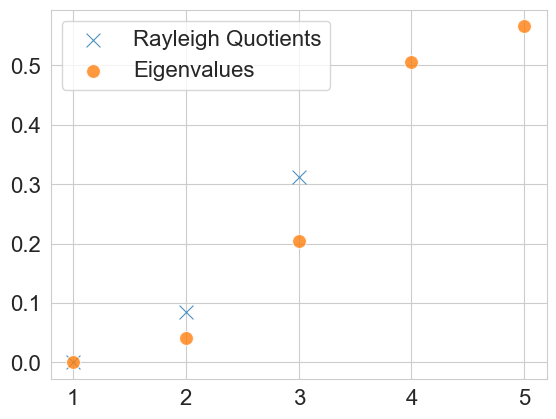

In [37]:
# plot of eigenvalues and rayleigh quotients
sns.scatterplot(x=[1, 2, 3], y=rayleigh_quotients, alpha=0.8, marker='x', s=100, label='Rayleigh Quotients')
sns.scatterplot(x=[1, 2, 3, 4, 5], y=normalized_L_eigenvalues[0:5], alpha=0.8, marker='o', s=100, label='Eigenvalues')
plt.legend()

In [38]:
true_val_matrix_combined = normalized_L_eigenvectors[:, :3] - indicator_vectors @ (
        indicator_vectors.T @ normalized_L_eigenvectors[:, :3])
true_val_combined = (1 / 3) * np.linalg.norm(true_val_matrix_combined) ** 2

rayleigh_quotients = np.round(rayleigh_quotients, 6)
normalized_L_eigenvalues = np.round(normalized_L_eigenvalues, 6)

#b, v = apply_recursive_st_search(rayleigh_quotients[0:4], normalized_L_eigenvalues[0:4], 0, error = 0, bound_indices = [], values = [])
v = apply_recursive_st_given_indices(rayleigh_quotients[0:4], normalized_L_eigenvalues[0:5], [0,1,3])


wine_dataset_results = {}
print("K: ", K)
wine_dataset_results["K"] = K
print("Number of vertices N: ", len(adjacency_matrix))
wine_dataset_results["N"] = len(adjacency_matrix)
print("Number of edges M: ", np.sum(np.sum(adjacency_matrix, axis=1), axis=0))
wine_dataset_results["M"] = np.sum(np.sum(adjacency_matrix, axis=1), axis=0)
print("True value: ", true_val_combined)
wine_dataset_results["True Value"] = true_val_combined
print("M&S ST: ", max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K])
wine_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ normalized_laplacian @ indicator_vectors))/normalized_L_eigenvalues[K]
print("General ST: ", np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K]))
wine_dataset_results["General ST"] = np.sum(rayleigh_quotients)/(K * normalized_L_eigenvalues[K])
print("Recursive ST: ", np.sum(v)/3)
wine_dataset_results["Recursive ST"] = np.sum(v)/3

dataset_results["Wine"] = wine_dataset_results

0.0
0.6724428378780111
K:  3
Number of vertices N:  178
Number of edges M:  6890.0
True value:  0.06456321090483377
M&S ST:  0.4498140716518029
General ST:  0.2608675038669646
Recursive ST:  0.2241476126260037


In [39]:
pd.DataFrame(dataset_results).T

,K,N,M,True Value,M&S ST,General ST,Recursive ST
Fashion MNIST,3.0,2875.0,1711217.0,0.043415,1.016065,0.535337,0.479182
IRIS,3.0,150.0,1027.0,0.059932,0.645794,0.336040,0.336040
Wine,3.0,178.0,6890.0,0.064563,0.449814,0.260868,0.224148


In [40]:
np.round(pd.DataFrame(dataset_results).T,4)

,K,N,M,True Value,M&S ST,General ST,Recursive ST
Fashion MNIST,3.0,2875.0,1711217.0,0.0434,1.0161,0.5353,0.4792
IRIS,3.0,150.0,1027.0,0.0599,0.6458,0.3360,0.3360
Wine,3.0,178.0,6890.0,0.0646,0.4498,0.2609,0.2241


# Test Datasets

## Air Quality Dataset

In [9]:
pollution_df = pd.read_csv("Data/updated_pollution_dataset.csv")
pollution_df = pollution_df.sort_values(by='Air Quality').reset_index(drop=True)

# Separate targets and features
pollution_df_targets = pollution_df['Air Quality']
pollution_df_features = pollution_df.drop(columns=['Air Quality'])

# Normalize features
pollution_df_features_normalized = (pollution_df_features - pollution_df_features.mean()) / pollution_df_features.std()

# Calculate covariance matrix
pollution_df_features_cov = np.cov(pollution_df_features_normalized)

# Threshold covariance matrix
pollution_df_features_cov_thresholded = pollution_df_features_cov.copy()
pollution_df_features_cov_thresholded[pollution_df_features_cov_thresholded < 0.4] = 0
pollution_df_features_cov_thresholded[pollution_df_features_cov_thresholded >= 0.4] = 1

In [10]:
# Remove zero rows and columns
non_zero_indices = np.where(~(pollution_df_features_cov_thresholded == 0).all(axis=1))[0]
pollution_df_features_cov_thresholded = pollution_df_features_cov_thresholded[non_zero_indices][:, non_zero_indices]

# Adjacency matrix
adjacency_matrix = pollution_df_features_cov_thresholded.copy()

<Axes: >

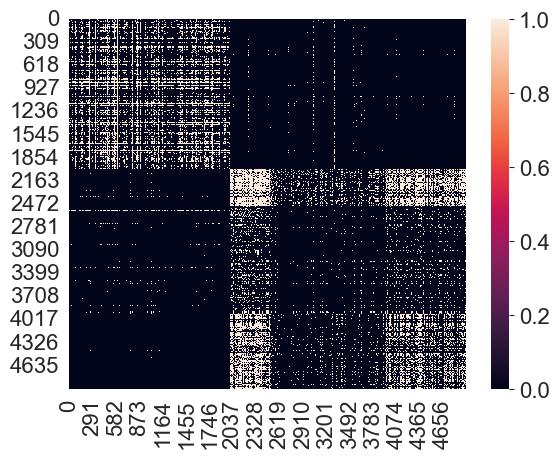

In [11]:
sns.heatmap(adjacency_matrix)

In [12]:
normalized_laplacian = get_normalised_laplacian(adjacency_matrix)

# compute first K eigenvectors of the normalized Laplacian
K = 3
normalized_L_eigenvalues, normalized_L_eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = normalized_L_eigenvalues.argsort()
normalized_L_eigenvalues = normalized_L_eigenvalues[idx]
normalized_L_eigenvectors = normalized_L_eigenvectors[:, idx]

indicator_vectors = k_means_indicator_vectors(normalized_L_eigenvectors[:, 0:K], K)
degrees = np.sum(adjacency_matrix, axis=0)
D_sqrt = np.diag(np.sqrt(degrees))

indicator_vectors = degree_correction(indicator_vectors, D_sqrt)
beta_K_by_K = indicator_vectors.T @ normalized_L_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(K):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                     i]) * combined_indicator_vectors[:, j]

rayleigh_quotients = compute_rayleigh_quotients(normalized_laplacian, combined_indicator_vectors, K)
rayleigh_quotients = np.sort(rayleigh_quotients)

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: >

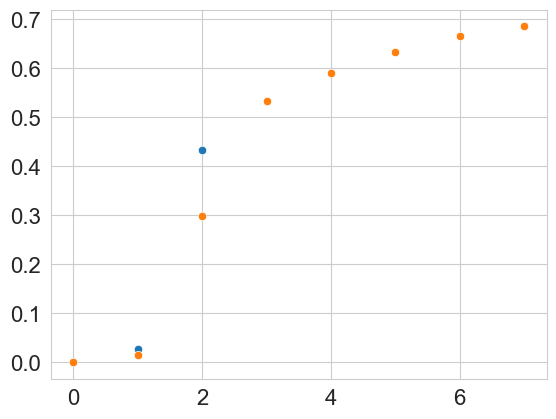

In [13]:
sns.scatterplot(rayleigh_quotients)
sns.scatterplot(normalized_L_eigenvalues[:8])

In [24]:
v = apply_recursive_st_given_indices(rayleigh_quotients[0:3], normalized_L_eigenvalues[0:4], [0,1,2,3])
np.sum(v)/3

-9.870191826038377e-15
0.038693429254788074
0.6661970431867594


0.2349634908138459

## GEMSEC DEEZER DATASET (SNAP)


In [45]:
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh 
import urllib.request
import os
import zipfile

# Step 1: Define the file path
edge_list_path = "Data/deezer_clean_data/RO_edges.csv"
df = pd.read_csv(edge_list_path)
df.to_csv("Data/cleaned_edges.csv", index=False, header=False)
# Step 2: Load the Deezer graph
# Assuming the edge list is in CSV format with two columns: source and target
G = nx.read_edgelist("Data/cleaned_edges.csv",delimiter=",", nodetype=int, data=False)

laplacian_sparse = nx.normalized_laplacian_matrix(G).astype(np.float64)

degrees = dict(G.degree())
# Compute the square root of the degrees
inv_sqrt_degrees = np.array([1/ np.sqrt(degrees[node]) if degrees[node] != 0 else 0 for node in G.nodes()])


# Step 4: Compute the smallest 6 eigenvalues of the Laplacian (for example)
num_eigenvalues = 20
eigenvalues, eigenvectors = eigsh(laplacian_sparse, k=num_eigenvalues, which="SM")

# Output results
print("\nEigenvalues of the Laplacian:")
print(eigenvalues)


Eigenvalues of the Laplacian:
[-3.79838924e-17  1.89109467e-02  2.06386062e-02  2.25914364e-02
  2.30252011e-02  2.74375325e-02  2.77013116e-02  2.91064629e-02
  3.24394616e-02  3.33049347e-02  3.41340977e-02  3.51331284e-02
  3.62451961e-02  4.30716533e-02  4.42180929e-02  4.47308256e-02
  4.72981701e-02  4.80126047e-02  4.86674360e-02  4.93608205e-02]


<Axes: >

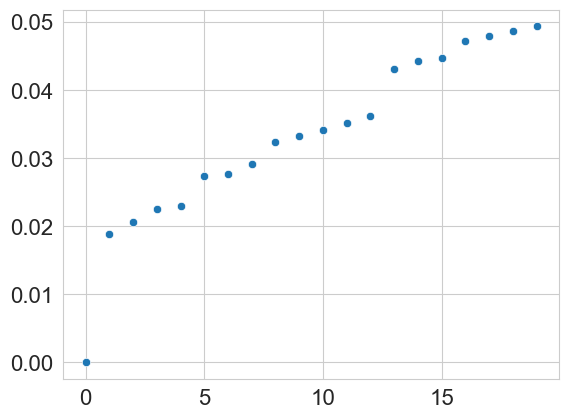

In [46]:
sns.scatterplot(eigenvalues)

In [47]:
from sklearn.cluster import KMeans
K = 3
# Perform K-means clustering on the eigenvectors
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
scaled_eigenvectors = inv_sqrt_degrees[:,np.newaxis] * eigenvectors

clusters = kmeans.fit_predict(scaled_eigenvectors[:,:K])


In [48]:
degrees = dict(G.degree())
# Compute the square root of the degrees
sqrt_degrees = np.array([np.sqrt(degrees[node]) for node in G.nodes()])

# Compute Rayleigh quotients for each cluster
rayleigh_quotients = []
indicator_vectors = np.zeros(eigenvectors.shape)

for cluster_idx in range(K):
    # Create indicator vector for the cluster
    indicator_vector = (clusters == cluster_idx).astype(float) * sqrt_degrees
    indicator_vector = indicator_vector / np.linalg.norm(indicator_vector, 2)
    indicator_vectors[:,cluster_idx] = indicator_vector
    # Compute Rayleigh quotient
    numerator = indicator_vector.T @ laplacian_sparse @ indicator_vector
    denominator = indicator_vector.T @ indicator_vector
    rayleigh_quotients.append(numerator / denominator)

rayleigh_quotients = sorted(rayleigh_quotients)

In [49]:
beta_K_by_K = indicator_vectors.T @ scaled_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
combined_rayleigh_quotients = []
for i in range(K):
    numerator = combined_indicator_vectors[:,i].T @ laplacian_sparse @ combined_indicator_vectors[:,i]
    denominator = combined_indicator_vectors[:,i].T @ combined_indicator_vectors[:,i]
    combined_rayleigh_quotients.append(numerator / denominator)
    
combined_rayleigh_quotients = sorted(combined_rayleigh_quotients)
    

<Axes: >

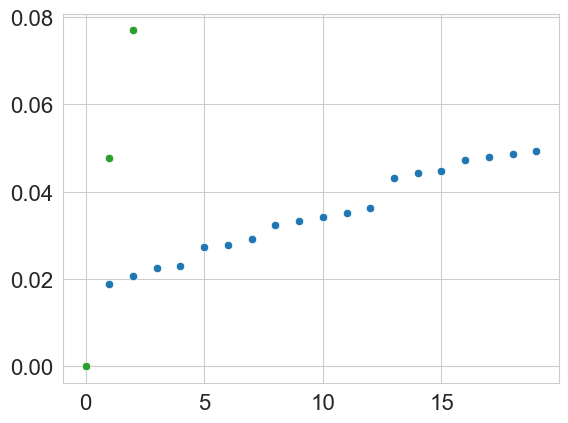

In [50]:
sns.scatterplot(eigenvalues)
sns.scatterplot(rayleigh_quotients)
sns.scatterplot(combined_rayleigh_quotients)

## Twitch 


Eigenvalues of the Laplacian:
[-1.49255409e-16  1.08241298e-01  1.33718984e-01  1.50752124e-01
  1.63661113e-01  1.67765911e-01  1.84350772e-01  1.87884480e-01
  1.89326959e-01  1.98710492e-01  2.03873360e-01  2.11466237e-01
  2.18909479e-01  2.45404022e-01  2.45524390e-01  2.74171858e-01
  2.76505637e-01  2.77181707e-01  2.78134133e-01  2.78162756e-01]


<Axes: >

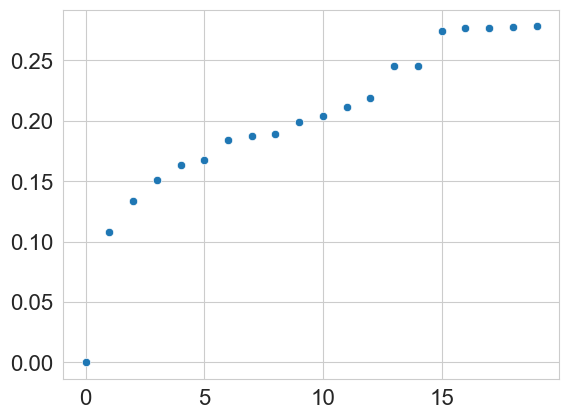

In [80]:
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh

# Step 1: Define the file path
edge_list_path = "Data/twitch_gamers/large_twitch_edges.csv"
df = pd.read_csv(edge_list_path)
df.to_csv("Data/twitch_gamers/twitch_cleaned_edges.csv", index=False, header=False)
# Step 2: Load the Deezer graph
# Assuming the edge list is in CSV format with two columns: source and target
G = nx.read_edgelist("Data/twitch_gamers/twitch_cleaned_edges.csv", delimiter=",", nodetype=int, data=False)

laplacian_sparse = nx.normalized_laplacian_matrix(G).astype(np.float64)

degrees = dict(G.degree())
# Compute the square root of the degrees
inv_sqrt_degrees = np.array([1 / np.sqrt(degrees[node]) if degrees[node] != 0 else 0 for node in G.nodes()])

# Step 4: Compute the smallest 6 eigenvalues of the Laplacian (for example)
num_eigenvalues = 20
eigenvalues, eigenvectors = eigsh(laplacian_sparse, k=num_eigenvalues, which="SM")

# Output results
print("\nEigenvalues of the Laplacian:")
print(eigenvalues)
sns.scatterplot(eigenvalues)

In [81]:

from sklearn.cluster import KMeans

K = 2
# Perform K-means clustering on the eigenvectors
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
scaled_eigenvectors = inv_sqrt_degrees[:, np.newaxis] * eigenvectors

clusters = kmeans.fit_predict(scaled_eigenvectors[:, :K])

degrees = dict(G.degree())
# Compute the square root of the degrees
sqrt_degrees = np.array([np.sqrt(degrees[node]) for node in G.nodes()])

# Compute Rayleigh quotients for each cluster
rayleigh_quotients = []
indicator_vectors = np.zeros(eigenvectors.shape)

for cluster_idx in range(K):
    # Create indicator vector for the cluster
    indicator_vector = (clusters == cluster_idx).astype(float) * sqrt_degrees
    indicator_vector = indicator_vector / np.linalg.norm(indicator_vector, 2)
    indicator_vectors[:, cluster_idx] = indicator_vector
    # Compute Rayleigh quotient
    numerator = indicator_vector.T @ laplacian_sparse @ indicator_vector
    denominator = indicator_vector.T @ indicator_vector
    rayleigh_quotients.append(numerator / denominator)

rayleigh_quotients = sorted(rayleigh_quotients)
beta_K_by_K = indicator_vectors.T @ scaled_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
combined_rayleigh_quotients = []
for i in range(K):
    numerator = combined_indicator_vectors[:, i].T @ laplacian_sparse @ combined_indicator_vectors[:, i]
    denominator = combined_indicator_vectors[:, i].T @ combined_indicator_vectors[:, i]
    combined_rayleigh_quotients.append(numerator / denominator)

combined_rayleigh_quotients = sorted(combined_rayleigh_quotients)

<Axes: >

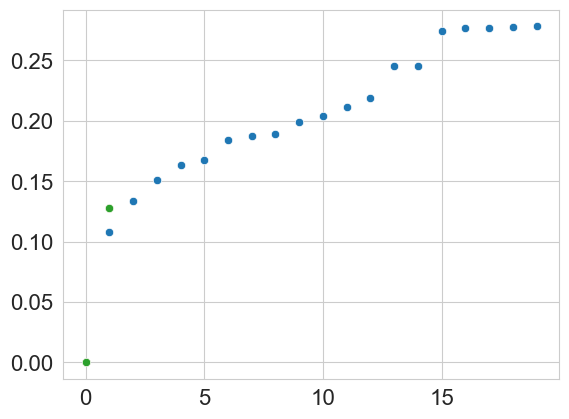

In [82]:

sns.scatterplot(eigenvalues)
sns.scatterplot(rayleigh_quotients)
sns.scatterplot(combined_rayleigh_quotients)

In [84]:
v = apply_recursive_st_given_indices(combined_rayleigh_quotients, eigenvalues[0:K+1], [0,1,2])


twitch_dataset_results = {}
print("K: ", K)
twitch_dataset_results["K"] = K
print("Number of vertices N: ", len(adjacency_matrix))
twitch_dataset_results["N"] = len(adjacency_matrix)
print("Number of edges M: ", np.sum(np.sum(adjacency_matrix, axis=1), axis=0))
twitch_dataset_results["M"] = np.sum(np.sum(adjacency_matrix, axis=1), axis=0)

print("M&S ST: ", max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors))/eigenvalues[K])
twitch_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors))/eigenvalues[K]
print("General ST: ", np.sum(combined_rayleigh_quotients)/(K * eigenvalues[K]))
twitch_dataset_results["General ST"] = np.sum(combined_rayleigh_quotients)/(K * eigenvalues[K])
print("Recursive ST: ", np.sum(v)/K)
twitch_dataset_results["Recursive ST"] = np.sum(v)/K

0.000718169792829956
0.784800217425459
K:  2
Number of vertices N:  4942
Number of edges M:  2784780.0
M&S ST:  0.9566943491158001
General ST:  0.47943040872370696
Recursive ST:  0.39275919360914446


In [66]:
E_1 = (combined_rayleigh_quotients[0] - eigenvalues[0])/(eigenvalues[1])
E_2 = (combined_rayleigh_quotients[1] - eigenvalues[1] + eigenvalues[2] * E_1)/(eigenvalues[2] - eigenvalues[1])
E_2/2

0.39240010871273395

In [72]:
rayleigh_quotients

[0.00025316431440172357, 0.1279281963427803]

In [70]:
(E_2 + E_1)/2

0.39275919360914724

## Last Fm Asia


Eigenvalues of the Laplacian:
[2.47956143e-16 9.45114344e-03 1.55102719e-02 2.02931311e-02
 2.22635399e-02 2.55930068e-02 3.51591003e-02 3.85575664e-02
 3.93633412e-02 3.98856014e-02 4.04416776e-02 4.26235007e-02
 4.63399762e-02 5.27550468e-02 5.49810748e-02 5.61977716e-02
 5.65333670e-02 5.90607683e-02 6.47386878e-02 6.51394599e-02]


<Axes: >

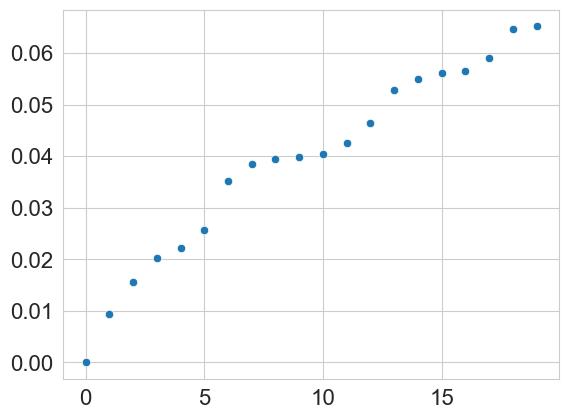

In [85]:
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh

# Step 1: Define the file path
edge_list_path = "Data/lasftm_asia/lastfm_asia_edges.csv"
df = pd.read_csv(edge_list_path)
df.to_csv("Data/lasftm_asia/lastfm_asia_edges.csv", index=False, header=False)
# Step 2: Load the Deezer graph
# Assuming the edge list is in CSV format with two columns: source and target
G = nx.read_edgelist("Data/lasftm_asia/lastfm_asia_edges.csv", delimiter=",", nodetype=int, data=False)

laplacian_sparse = nx.normalized_laplacian_matrix(G).astype(np.float64)

degrees = dict(G.degree())
# Compute the square root of the degrees
inv_sqrt_degrees = np.array([1 / np.sqrt(degrees[node]) if degrees[node] != 0 else 0 for node in G.nodes()])

# Step 4: Compute the smallest 6 eigenvalues of the Laplacian (for example)
num_eigenvalues = 20
eigenvalues, eigenvectors = eigsh(laplacian_sparse, k=num_eigenvalues, which="SM")

# Output results
print("\nEigenvalues of the Laplacian:")
print(eigenvalues)
sns.scatterplot(eigenvalues)

In [95]:

from sklearn.cluster import KMeans

K = 6
# Perform K-means clustering on the eigenvectors
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
scaled_eigenvectors = inv_sqrt_degrees[:, np.newaxis] * eigenvectors

clusters = kmeans.fit_predict(scaled_eigenvectors[:, :K])

degrees = dict(G.degree())
# Compute the square root of the degrees
sqrt_degrees = np.array([np.sqrt(degrees[node]) for node in G.nodes()])

# Compute Rayleigh quotients for each cluster
rayleigh_quotients = []
indicator_vectors = np.zeros(eigenvectors.shape)

for cluster_idx in range(K):
    # Create indicator vector for the cluster
    indicator_vector = (clusters == cluster_idx).astype(float) * sqrt_degrees
    indicator_vector = indicator_vector / np.linalg.norm(indicator_vector, 2)
    indicator_vectors[:, cluster_idx] = indicator_vector
    # Compute Rayleigh quotient
    numerator = indicator_vector.T @ laplacian_sparse @ indicator_vector
    denominator = indicator_vector.T @ indicator_vector
    rayleigh_quotients.append(numerator / denominator)

rayleigh_quotients = sorted(rayleigh_quotients)
beta_K_by_K = indicator_vectors.T @ scaled_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
combined_rayleigh_quotients = []
for i in range(K):
    numerator = combined_indicator_vectors[:, i].T @ laplacian_sparse @ combined_indicator_vectors[:, i]
    denominator = combined_indicator_vectors[:, i].T @ combined_indicator_vectors[:, i]
    combined_rayleigh_quotients.append(numerator / denominator)

combined_rayleigh_quotients = sorted(combined_rayleigh_quotients)

0.03935883029519242
5.1321124899708535


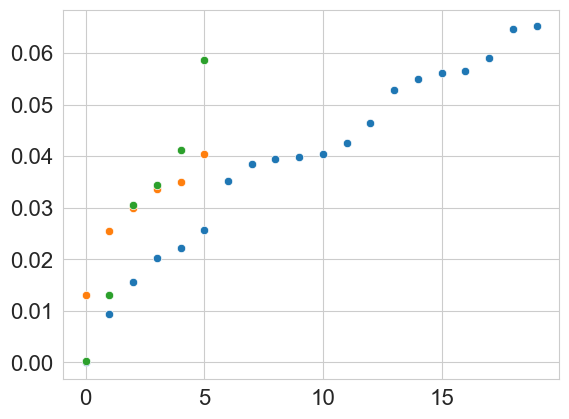

In [96]:

sns.scatterplot(eigenvalues)
sns.scatterplot(rayleigh_quotients)
sns.scatterplot(combined_rayleigh_quotients)
v = apply_recursive_st_given_indices(combined_rayleigh_quotients, eigenvalues[0:K + 1], [0,1, K])

In [98]:

lastfm_dataset_results = {}
print("K: ", K)
lastfm_dataset_results["K"] = K

print("M&S ST: ", max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors)) / eigenvalues[K])
lastfm_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors)) / \
                                   eigenvalues[K]
print("General ST: ", np.sum(combined_rayleigh_quotients) / (K * eigenvalues[K]))
lastfm_dataset_results["General ST"] = np.sum(combined_rayleigh_quotients) / (K * eigenvalues[K])
print("Recursive ST: ", np.sum(v) / K)
lastfm_dataset_results["Recursive ST"] = np.sum(v) / K

K:  6
M&S ST:  1.149788576219157
General ST:  0.8446367467784104
Recursive ST:  0.8619118867110077


## Gemsec Facebook - Athletes


Eigenvalues of the Laplacian:
[-1.01444082e-16  1.40582480e-02  1.55717317e-02  3.68857664e-02
  4.72367886e-02  5.06513563e-02  5.80770587e-02  6.26108119e-02
  6.53871384e-02  6.75338995e-02  6.90625910e-02  7.40660413e-02
  7.98991963e-02  8.11414161e-02  8.17376674e-02  8.70893479e-02
  8.93567229e-02  8.99040173e-02  9.35597547e-02  9.60190769e-02]


<Axes: >

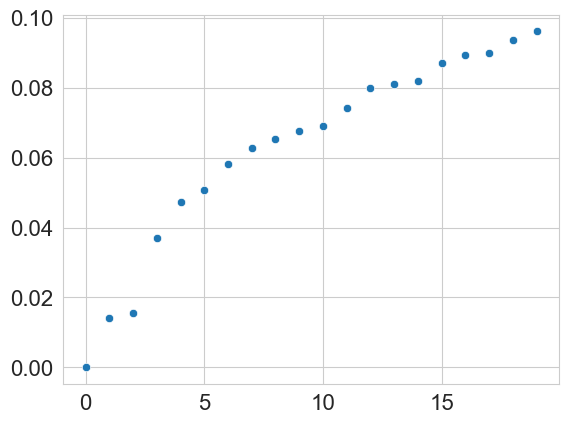

In [209]:
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh

# Step 1: Define the file path
edge_list_path = "Data/facebook_clean_data/athletes_edges.csv"
df = pd.read_csv(edge_list_path)
df.to_csv("Data/facebook_clean_data/athletes_edges.csv", index=False, header=False)
# Step 2: Load the Deezer graph
# Assuming the edge list is in CSV format with two columns: source and target
G = nx.read_edgelist("Data/facebook_clean_data/athletes_edges.csv", delimiter=",", nodetype=int, data=False)

laplacian_sparse = nx.normalized_laplacian_matrix(G).astype(np.float64)

degrees = dict(G.degree())
# Compute the square root of the degrees
inv_sqrt_degrees = np.array([1 / np.sqrt(degrees[node]) if degrees[node] != 0 else 0 for node in G.nodes()])

# Step 4: Compute the smallest 6 eigenvalues of the Laplacian (for example)
num_eigenvalues = 20
eigenvalues, eigenvectors = eigsh(laplacian_sparse, k=num_eigenvalues, which="SM")

# Output results
print("\nEigenvalues of the Laplacian:")
print(eigenvalues)
sns.scatterplot(eigenvalues)

In [121]:

from sklearn.cluster import KMeans

K = 3
# Perform K-means clustering on the eigenvectors
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
scaled_eigenvectors = inv_sqrt_degrees[:, np.newaxis] * eigenvectors

clusters = kmeans.fit_predict(scaled_eigenvectors[:, :K])

degrees = dict(G.degree())
# Compute the square root of the degrees
sqrt_degrees = np.array([np.sqrt(degrees[node]) for node in G.nodes()])

# Compute Rayleigh quotients for each cluster
rayleigh_quotients = []
indicator_vectors = np.zeros(eigenvectors.shape)

for cluster_idx in range(K):
    # Create indicator vector for the cluster
    indicator_vector = (clusters == cluster_idx).astype(float) * sqrt_degrees
    indicator_vector = indicator_vector / np.linalg.norm(indicator_vector, 2)
    indicator_vectors[:, cluster_idx] = indicator_vector
    # Compute Rayleigh quotient
    numerator = indicator_vector.T @ laplacian_sparse @ indicator_vector
    denominator = indicator_vector.T @ indicator_vector
    rayleigh_quotients.append(numerator / denominator)

rayleigh_quotients = sorted(rayleigh_quotients)
beta_K_by_K = indicator_vectors.T @ scaled_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
combined_rayleigh_quotients = []
for i in range(K):
    numerator = combined_indicator_vectors[:, i].T @ laplacian_sparse @ combined_indicator_vectors[:, i]
    denominator = combined_indicator_vectors[:, i].T @ combined_indicator_vectors[:, i]
    combined_rayleigh_quotients.append(numerator / denominator)

combined_rayleigh_quotients = sorted(combined_rayleigh_quotients)

<Axes: >

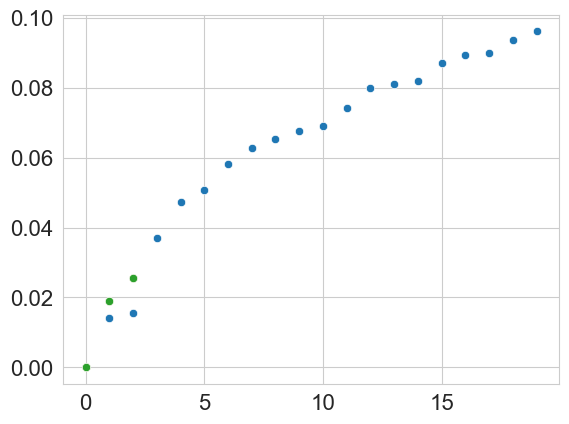

In [122]:

sns.scatterplot(eigenvalues)
sns.scatterplot(rayleigh_quotients)
sns.scatterplot(combined_rayleigh_quotients)

In [127]:

v = apply_recursive_st_given_indices(combined_rayleigh_quotients, eigenvalues[0:K + 1], [0,1, K])

lastfm_dataset_results = {}
print("K: ", K)
lastfm_dataset_results["K"] = K

print("M&S ST: ", max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors)) / eigenvalues[K])
lastfm_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors)) / \
                                   eigenvalues[K]
print("General ST: ", np.sum(combined_rayleigh_quotients) / (K * eigenvalues[K]))
lastfm_dataset_results["General ST"] = np.sum(combined_rayleigh_quotients) / (K * eigenvalues[K])
print("Recursive ST: ", np.sum(v) / K)
lastfm_dataset_results["Recursive ST"] = np.sum(v) / K

0.0011871410473172131
0.7246510303406326
K:  3
M&S ST:  0.6951468871795993
General ST:  0.4033297481914648
Recursive ST:  0.2419460571293166


## Facebook Gemsec data company graph

In [166]:
# Step 1: Define the file path
edge_list_path = "Data/facebook_clean_data/tvshow_edges.csv"
df = pd.read_csv(edge_list_path)
df.to_csv("Data/facebook_clean_data/tvshow_edges.csv", index=False, header=False)
# Step 2: Load the Deezer graph
# Assuming the edge list is in CSV format with two columns: source and target
G = nx.read_edgelist("Data/facebook_clean_data/tvshow_edges.csv", delimiter=",", nodetype=int, data=False)

laplacian_sparse = nx.normalized_laplacian_matrix(G).astype(np.float64)

degrees = dict(G.degree())
# Compute the square root of the degrees
inv_sqrt_degrees = np.array([1 / np.sqrt(degrees[node]) if degrees[node] != 0 else 0 for node in G.nodes()])

# Step 4: Compute the smallest 6 eigenvalues of the Laplacian (for example)
num_eigenvalues = 20
eigenvalues, eigenvectors = eigsh(laplacian_sparse, k=num_eigenvalues, which="SM")


Eigenvalues of the Laplacian:
[-1.38482699e-16  2.73960523e-03  5.70609974e-03  6.47732246e-03
  6.97678544e-03  7.88744049e-03  8.40633757e-03  8.49900057e-03
  9.44927117e-03  9.78590098e-03  1.00547935e-02  1.03363799e-02
  1.05042880e-02  1.13882166e-02  1.18226122e-02  1.28594449e-02
  1.32282869e-02  1.40560432e-02  1.50276603e-02  1.52115982e-02]


<Axes: >

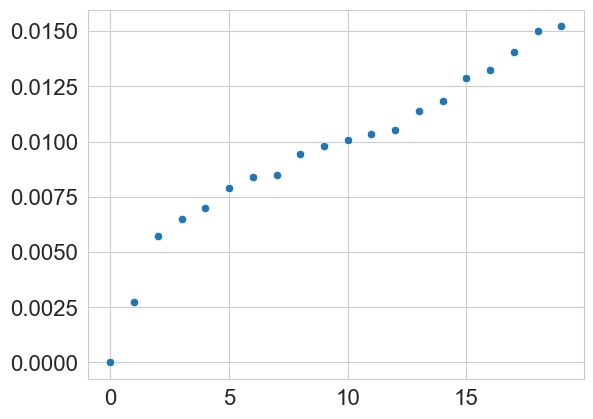

In [167]:

# Output results
print("\nEigenvalues of the Laplacian:")
print(eigenvalues)
sns.scatterplot(eigenvalues)

In [168]:

from sklearn.cluster import KMeans

K = 3
# Perform K-means clustering on the eigenvectors
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
scaled_eigenvectors = inv_sqrt_degrees[:, np.newaxis] * eigenvectors

clusters = kmeans.fit_predict(scaled_eigenvectors[:, :K])

degrees = dict(G.degree())
# Compute the square root of the degrees
sqrt_degrees = np.array([np.sqrt(degrees[node]) for node in G.nodes()])

# Compute Rayleigh quotients for each cluster
rayleigh_quotients = []
indicator_vectors = np.zeros(eigenvectors.shape)

for cluster_idx in range(K):
    # Create indicator vector for the cluster
    indicator_vector = (clusters == cluster_idx).astype(float) * sqrt_degrees
    indicator_vector = indicator_vector / np.linalg.norm(indicator_vector, 2)
    indicator_vectors[:, cluster_idx] = indicator_vector
    # Compute Rayleigh quotient
    numerator = indicator_vector.T @ laplacian_sparse @ indicator_vector
    denominator = indicator_vector.T @ indicator_vector
    rayleigh_quotients.append(numerator / denominator)

rayleigh_quotients = sorted(rayleigh_quotients)
beta_K_by_K = indicator_vectors.T @ scaled_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
combined_rayleigh_quotients = []
for i in range(K):
    numerator = combined_indicator_vectors[:, i].T @ laplacian_sparse @ combined_indicator_vectors[:, i]
    denominator = combined_indicator_vectors[:, i].T @ combined_indicator_vectors[:, i]
    combined_rayleigh_quotients.append(numerator / denominator)

combined_rayleigh_quotients = sorted(combined_rayleigh_quotients)

<Axes: >

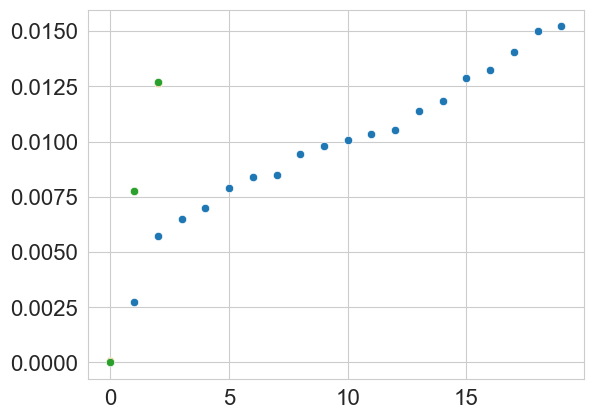

In [169]:

sns.scatterplot(eigenvalues)
sns.scatterplot(rayleigh_quotients)
sns.scatterplot(combined_rayleigh_quotients)

In [170]:

v = apply_recursive_st_given_indices(combined_rayleigh_quotients, eigenvalues[0:K + 1], [0, 1, K])

lastfm_dataset_results = {}
print("K: ", K)
lastfm_dataset_results["K"] = K

print("M&S ST: ", max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors)) / eigenvalues[K])
lastfm_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors)) / \
                                   eigenvalues[K]
print("General ST: ", np.sum(combined_rayleigh_quotients) / (K * eigenvalues[K]))
lastfm_dataset_results["General ST"] = np.sum(combined_rayleigh_quotients) / (K * eigenvalues[K])
print("Recursive ST: ", np.sum(v) / K)
lastfm_dataset_results["Recursive ST"] = np.sum(v) / K

0.01258650930384461
4.030516894615576
K:  3
M&S ST:  1.9542377155595738
General ST:  1.05481332313077
Recursive ST:  1.3477011346398067


## Facebook Large

In [172]:

# Step 1: Define the file path
edge_list_path = "Data/facebook_large/musae_facebook_edges.csv"
df = pd.read_csv(edge_list_path)
df.to_csv("Data/facebook_large/musae_facebook_edges.csv", index=False, header=False)
# Step 2: Load the Deezer graph
# Assuming the edge list is in CSV format with two columns: source and target
G = nx.read_edgelist("Data/facebook_large/musae_facebook_edges.csv", delimiter=",", nodetype=int, data=False)

laplacian_sparse = nx.normalized_laplacian_matrix(G).astype(np.float64)

degrees = dict(G.degree())
# Compute the square root of the degrees
inv_sqrt_degrees = np.array([1 / np.sqrt(degrees[node]) if degrees[node] != 0 else 0 for node in G.nodes()])

# Step 4: Compute the smallest 6 eigenvalues of the Laplacian (for example)
num_eigenvalues = 20
eigenvalues, eigenvectors = eigsh(laplacian_sparse, k=num_eigenvalues, which="SM")
# Output results
print("\nEigenvalues of the Laplacian:")
print(eigenvalues)


Eigenvalues of the Laplacian:
[1.92456296e-17 4.43977654e-03 7.89526270e-03 8.21886139e-03
 8.46343351e-03 9.31604794e-03 9.62081979e-03 1.17076869e-02
 1.20284677e-02 1.34378418e-02 1.43222871e-02 1.52156131e-02
 1.55376026e-02 1.81106175e-02 1.89080903e-02 1.93186213e-02
 2.02962173e-02 2.03990134e-02 2.08947949e-02 2.11393703e-02]


<Axes: >

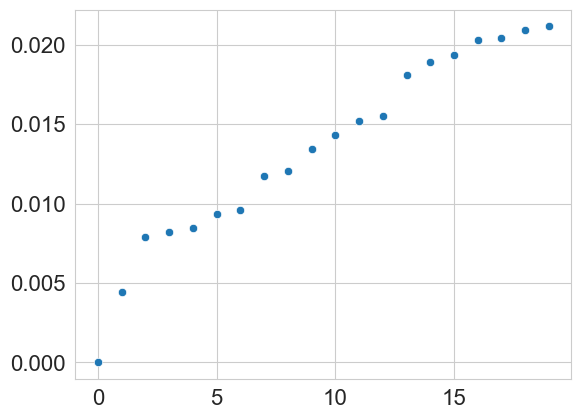

In [173]:
sns.scatterplot(eigenvalues)

In [177]:

from sklearn.cluster import KMeans

K = 2
# Perform K-means clustering on the eigenvectors
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
scaled_eigenvectors = inv_sqrt_degrees[:, np.newaxis] * eigenvectors

clusters = kmeans.fit_predict(scaled_eigenvectors[:, :K])

degrees = dict(G.degree())
# Compute the square root of the degrees
sqrt_degrees = np.array([np.sqrt(degrees[node]) for node in G.nodes()])

# Compute Rayleigh quotients for each cluster
rayleigh_quotients = []
indicator_vectors = np.zeros(eigenvectors.shape)

for cluster_idx in range(K):
    # Create indicator vector for the cluster
    indicator_vector = (clusters == cluster_idx).astype(float) * sqrt_degrees
    indicator_vector = indicator_vector / np.linalg.norm(indicator_vector, 2)
    indicator_vectors[:, cluster_idx] = indicator_vector
    # Compute Rayleigh quotient
    numerator = indicator_vector.T @ laplacian_sparse @ indicator_vector
    denominator = indicator_vector.T @ indicator_vector
    rayleigh_quotients.append(numerator / denominator)

rayleigh_quotients = sorted(rayleigh_quotients)
beta_K_by_K = indicator_vectors.T @ scaled_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
combined_rayleigh_quotients = []
for i in range(K):
    numerator = combined_indicator_vectors[:, i].T @ laplacian_sparse @ combined_indicator_vectors[:, i]
    denominator = combined_indicator_vectors[:, i].T @ combined_indicator_vectors[:, i]
    combined_rayleigh_quotients.append(numerator / denominator)

combined_rayleigh_quotients = sorted(combined_rayleigh_quotients)

<Axes: >

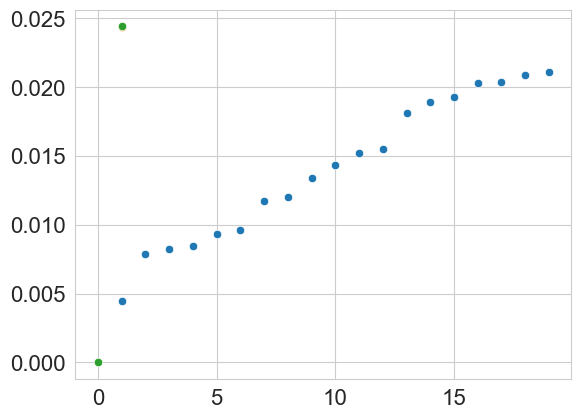

In [178]:

sns.scatterplot(eigenvalues)
sns.scatterplot(rayleigh_quotients)
sns.scatterplot(combined_rayleigh_quotients)

In [179]:

v = apply_recursive_st_given_indices(combined_rayleigh_quotients, eigenvalues[0:K + 1], [0, 1, K])

lastfm_dataset_results = {}
print("K: ", K)
lastfm_dataset_results["K"] = K

print("M&S ST: ", max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors)) / eigenvalues[K])
lastfm_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors)) / \
                                   eigenvalues[K]
print("General ST: ", np.sum(combined_rayleigh_quotients) / (K * eigenvalues[K]))
lastfm_dataset_results["General ST"] = np.sum(combined_rayleigh_quotients) / (K * eigenvalues[K])
print("Recursive ST: ", np.sum(v) / K)


0.0035189149799879364
5.788828694816217
K:  2
M&S ST:  3.0892251264341333
General ST:  1.5471831246782408
Recursive ST:  2.8961738048981025


## Collaborations CA-CondMat

In [197]:

# Step 1: Define the file path
# Define the file path for the input and output
input_file = "Data/ca-CondMat.txt/CA-CondMat.txt"  # Replace with your actual file path
output_file = "Data/ca-CondMat.txt/edge_list.txt"

# Initialize a set to store unique edges (to ensure undirected representation)
edge_set = set()

# Open the input file and process each line
with open(input_file, "r") as file:
    for line in file:
        # Skip comment lines starting with '#'
        if line.startswith("#"):
            continue

        # Split the line into nodes
        parts = line.strip().split()
        if len(parts) == 2:
            node1, node2 = parts

            # Add the edge in a sorted order to avoid duplicates (undirected graph)
            edge = tuple(sorted((int(node1), int(node2))))
            edge_set.add(edge)

# Write the unique edges to the output file
with open(output_file, "w") as file:
    for edge in sorted(edge_set):  # Sort edges for consistency
        file.write(f"{edge[0]}\t{edge[1]}\n")

print(f"Edge list extracted and saved to {output_file}")

Edge list extracted and saved to Data/ca-CondMat.txt/edge_list.txt



Eigenvalues of the Laplacian:
[3.79662067e-17 7.18641182e-03 8.03253697e-03 1.62162299e-02
 1.64606006e-02 1.76285597e-02 1.87091342e-02 1.94809592e-02
 1.97639921e-02 1.98565146e-02]


<Axes: >

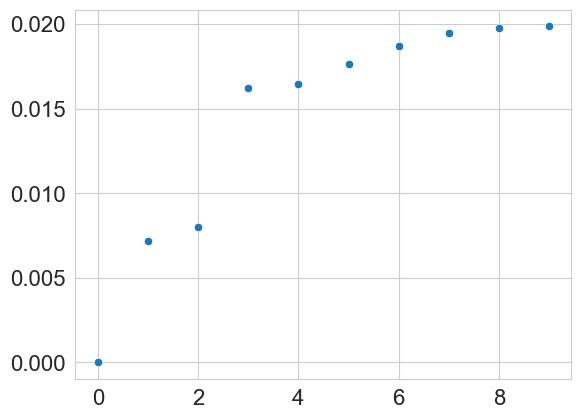

In [200]:

# Step 2: Load the Deezer graph
# Assuming the edge list is in CSV format with two columns: source and target
G = nx.read_edgelist("Data/ca-CondMat.txt/edge_list.txt", nodetype=int)
LCC_nodes = max(nx.connected_components(G), key=len)
G = G.subgraph(LCC_nodes)
laplacian_sparse = nx.normalized_laplacian_matrix(G).astype(np.float64)

degrees = dict(G.degree())
# Compute the square root of the degrees
inv_sqrt_degrees = np.array([1 / np.sqrt(degrees[node]) if degrees[node] != 0 else 0 for node in G.nodes()])

# Step 4: Compute the smallest 6 eigenvalues of the Laplacian (for example)
num_eigenvalues = 10
eigenvalues, eigenvectors = eigsh(laplacian_sparse, k=num_eigenvalues, which="SM")
# Output results
print("\nEigenvalues of the Laplacian:")
print(eigenvalues)
sns.scatterplot(eigenvalues)


In [201]:

from sklearn.cluster import KMeans

K = 3
# Perform K-means clustering on the eigenvectors
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
scaled_eigenvectors = inv_sqrt_degrees[:, np.newaxis] * eigenvectors

clusters = kmeans.fit_predict(scaled_eigenvectors[:, :K])

degrees = dict(G.degree())
# Compute the square root of the degrees
sqrt_degrees = np.array([np.sqrt(degrees[node]) for node in G.nodes()])

# Compute Rayleigh quotients for each cluster
rayleigh_quotients = []
indicator_vectors = np.zeros(eigenvectors.shape)

for cluster_idx in range(K):
    # Create indicator vector for the cluster
    indicator_vector = (clusters == cluster_idx).astype(float) * sqrt_degrees
    indicator_vector = indicator_vector / np.linalg.norm(indicator_vector, 2)
    indicator_vectors[:, cluster_idx] = indicator_vector
    # Compute Rayleigh quotient
    numerator = indicator_vector.T @ laplacian_sparse @ indicator_vector
    denominator = indicator_vector.T @ indicator_vector
    rayleigh_quotients.append(numerator / denominator)

rayleigh_quotients = sorted(rayleigh_quotients)
beta_K_by_K = indicator_vectors.T @ scaled_eigenvectors[:, 0:K]
combined_indicator_vectors = indicator_vectors @ beta_K_by_K
combined_rayleigh_quotients = []
for i in range(K):
    numerator = combined_indicator_vectors[:, i].T @ laplacian_sparse @ combined_indicator_vectors[:, i]
    denominator = combined_indicator_vectors[:, i].T @ combined_indicator_vectors[:, i]
    combined_rayleigh_quotients.append(numerator / denominator)

combined_rayleigh_quotients = sorted(combined_rayleigh_quotients)

<Axes: >

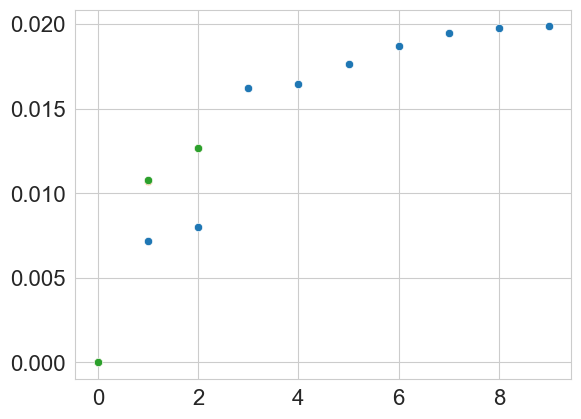

In [202]:
sns.scatterplot(eigenvalues)
sns.scatterplot(rayleigh_quotients)
sns.scatterplot(combined_rayleigh_quotients)

In [208]:

v = apply_recursive_st_given_indices(combined_rayleigh_quotients, eigenvalues[0:K + 1], [0,1, K])

lastfm_dataset_results = {}
print("K: ", K)
lastfm_dataset_results["K"] = K

print("M&S ST: ", max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors)) / eigenvalues[K])
lastfm_dataset_results["M&S ST"] = max(np.diag(indicator_vectors.T @ laplacian_sparse @ indicator_vectors)) / \
                                   eigenvalues[K]
print("General ST: ", np.sum(combined_rayleigh_quotients) / (K * eigenvalues[K]))
lastfm_dataset_results["General ST"] = np.sum(combined_rayleigh_quotients) / (K * eigenvalues[K])
print("Recursive ST: ", np.sum(v) / K)

0.000632805569419752
1.0043843862738715
K:  3
M&S ST:  0.7805900569513156
General ST:  0.48175023700693925
Recursive ST:  0.33500573061443045
